In [1]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Regularized Word Embeddings in Text Classification and in Ad-hoc IR
## 4. Document Representations

We consider three document representations:

- Vector Space Model (VSM)
- Soft Vector Space Model (Soft VSM)
- Latent Semantic Indexing (LSI)

We consider four term weighting schemes:

- Binary
- Bag of Words (BOW)
- TF-IDF
- Okapi BM25

And we consider two similarities:

- Inner Product (IP)
- Relaxed Word Mover's Distance (RWMD)

## 6. Evaluation

Not all combinations of document representations, term weighting schemes, and similarities are evaluated:

| ↓ Weights, Space and similarity → | VSM IP | VSM WMD | Soft VSM IP | LSI IP |
|--|--|--|--|--|
| Binary | ❌ | ❌ | ✅<sup>2</sup>  | ❌ |
| BOW | ✅ | ✅ | ✅<sup>1, 2</sup> | ❌ |
| TF-IDF | ✅ | ❌ | ✅ | ✅ |
| Okapi BM25 | ✅ | ❌ | ❌ | ❌ |

<sup>1</sup> We use non-normalized BOW queries, $L_1$-normalized BOW collection documents, and $L_1$-normalized inner product.  
<sup>2</sup> We only use the dense soft VSM. 

In [2]:
configurations = [
    # ('random', 'random', 'random', 'random'),
    ('vsm', 'bow', 'inner_product', 32),
    ('dense_soft_vsm', 'tfidf', 'inner_product', 32),
    ('dense_soft_vsm', 'tfidf', 'inner_product', 1),
    # ('vsm', 'bm25', 'inner_product', 32),
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 32),
    # ('lsi', 'tfidf', 'inner_product', 32),
    ('vsm', 'bow', 'wmd', 32),
    # ('vsm', 'tfidf', 'inner_product', 32),
    # ('dense_soft_vsm', 'binary', 'inner_product', 32),
    # ('dense_soft_vsm', 'binary', 'inner_product', 1),
    # ('dense_soft_vsm', 'bow', 'inner_product', 32),
    # ('dense_soft_vsm', 'bow', 'inner_product', 1),
    # ('vsm', 'bow', 'wmd', 1),
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 1),
]
configuration_names = {
    ('random', 'random', 'random', 'random'): 'Random',
    ('vsm', 'bow', 'inner_product', 32): 'BoW',
    ('vsm', 'tfidf', 'inner_product', 32): 'TF-IDF',
    ('vsm', 'bm25', 'inner_product', 32): 'Okapi BM25',
    ('lsi', 'tfidf', 'inner_product', 32): 'LSI',
    ('dense_soft_vsm', 'tfidf', 'inner_product', 32): 'Soft VSM',
    ('dense_soft_vsm', 'tfidf', 'inner_product', 1): 'Soft VSM (quan.)',
    ('dense_soft_vsm', 'bow', 'inner_product', 32): 'NTLM (32b)',
    ('dense_soft_vsm', 'bow', 'inner_product', 1): 'NTLM (1b)',
    ('dense_soft_vsm', 'binary', 'inner_product', 32): 'Query Expansion',
    ('dense_soft_vsm', 'binary', 'inner_product', 1): 'Query Expansion (1b)',
    ('vsm', 'bow', 'wmd', 32): 'WMD',
    ('vsm', 'bow', 'wmd', 1): 'WMD (quant.)',
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 32): r'Soft VSM (or.)',
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 1): r'Soft VSM (quan., or.)',
}

There are several parameters that are tuned by grid search.

- Soft VSM (sparse):
    - `symmetric`${}\in\{$ `True`, `False` $\}$
    - `positive_definite`${}\in\{$ `True`, `False` $\}$
    - `tfidf`${}\in\{$ `<TfidfModel>`, `None` $\}$
    - `nonzero_limit`${}\in\{100, 200, \ldots, 600\}$
- TFIDF:
    - `slope`${}\in\{0.0, 0.1, \ldots, 1.0\}$

   
### 6.1 Datasets


In [3]:
from math import sqrt

from common import ClassificationResult, KusnerEtAlClassificationResult

dataset_names = []
results = dict()

def load_results(name, test_error_height, error_bar_height, num_trials, speed_logs=()):
    """Loads classification results for a given dataset.
    
    Parameters
    ----------
    name : str
        The name of a dataset.
    test_error_height : scalar
        The height in pixels of a reported test error in Figure 3 of Kusner et al. (2015).
    error_bar_height : scalar
        The height in pixels of a reported error bar in Figure 3 of Kusner et al. (2015).
    num_trials : int
        The number of Bernoulli trials in the result.
    speed_logs : iterable of str, optional
        Text logs regarding processing speed of the Word Mover's Distance on this dataset.
    """

    dataset_names.append(name)
    results[name] = dict()
    datasets = None
    for configuration in configurations:
        if configuration == ('vsm', 'bow', 'wmd', 32):
            result = KusnerEtAlClassificationResult(
                test_error_height,
                error_bar_height,
                num_trials,
                {'speed_logs': list(speed_logs)},
            )
        else:
            basename = '{}-{}'.format(name, '-'.join(map(str, configuration)))
            try:
                result = ClassificationResult.from_file(basename)
            except IOError:
                if datasets is None:
                    import dataset
                    dataset_loader = dataset.__dict__['load_{}'.format(name)]
                    datasets = dataset_loader()
                train, validation, test = datasets
                result = train.classify(validation, test, *configuration)
                result.to_file(basename)
        results[name][configuration] = result

For classification, we use the following datasets:


- [BBCSport][BBC] (2005, 255K, 737 documents, *free*)

 [BBC]: http://mlg.ucd.ie/datasets/bbc.html (Insight - BBC Datasets)

In [4]:
load_results('bbcsport', 8.1537210257, 3.7399280445, 517 * 220)

2019-02-18 22:17:00,778 : INFO : Loading a classification result from file results/classification-bbcsport-vsm-bow-inner_product-32.pkl.xz.
2019-02-18 22:17:00,793 : INFO : Loading a classification result from file results/classification-bbcsport-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-18 22:17:00,794 : INFO : Loading a classification result from file results/classification-bbcsport-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-18 22:17:00,796 : INFO : Loading a classification result from file results/classification-bbcsport-vsm-bm25-inner_product-32.pkl.xz.
2019-02-18 22:17:00,806 : INFO : Loading a classification result from file results/classification-bbcsport-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-18 22:17:00,850 : INFO : Loading a classification result from file results/classification-bbcsport-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.


- [TWITTER][] (2011, 160K, 6.4k documents subsampled to 3,108 documents, *free*)

 [TWITTER]: https://web.archive.org/web/20180328044709/www.sananalytics.com/lab/twitter-sentiment/ (Sanders Analytics - Twitter Sentiment Corpus)

In [5]:
load_results('twitter', 50.1493982864, 3.29247, 2176 * 932)

2019-02-18 22:17:00,912 : INFO : Loading a classification result from file results/classification-twitter-vsm-bow-inner_product-32.pkl.xz.
2019-02-18 22:17:00,923 : INFO : Loading a classification result from file results/classification-twitter-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-18 22:17:00,925 : INFO : Loading a classification result from file results/classification-twitter-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-18 22:17:00,926 : INFO : Loading a classification result from file results/classification-twitter-vsm-bm25-inner_product-32.pkl.xz.
2019-02-18 22:17:00,927 : INFO : Loading a classification result from file results/classification-twitter-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-18 22:17:00,934 : INFO : Loading a classification result from file results/classification-twitter-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.



- [BBC] (2005, 864K, 2.23k documents, *free*)

 [BBC]: http://mlg.ucd.ie/datasets/bbc.html (Insight - BBC Datasets)

In [6]:
# load_results('bbc', load_bbc)


- [OHSUMED][] (1994, 24M, 50.22k documents, *free*)
    - We only use documents in a single category.
    - For computational efficiency, we subsample the dataset, using the first 10 classes.

 [OHSUMED]: http://disi.unitn.it/moschitti/corpora.htm (Donwloadable Corpora)


In [7]:
load_results('ohsumed', 77.7931252118, 1.34765, 3999 * 5153)

2019-02-18 22:17:01,000 : INFO : Loading a classification result from file results/classification-ohsumed-vsm-bow-inner_product-32.pkl.xz.
2019-02-18 22:17:01,024 : INFO : Loading a classification result from file results/classification-ohsumed-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-18 22:17:01,025 : INFO : Loading a classification result from file results/classification-ohsumed-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-18 22:17:01,027 : INFO : Loading a classification result from file results/classification-ohsumed-vsm-bm25-inner_product-32.pkl.xz.
2019-02-18 22:17:01,028 : INFO : Loading a classification result from file results/classification-ohsumed-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-18 22:17:01,069 : INFO : Loading a classification result from file results/classification-ohsumed-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.



- [Reuters-21578][] (1987, 8.2M, 215.78k documents, *free*)
    - We use the 8-class version with train / test split as described in [Cardoso-Cachopo (2007)][cardosocapocho07].

 [cardosocapocho07]: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.96.7709&rep=rep1&type=pdf (Improving Methods for Single-label Text Categorization)
 [Reuters-21578]: http://www.daviddlewis.com/resources/testcollections/reuters21578/ (Reuters-21578 Text Categorization Test Collection)

In [8]:
load_results('reuters', 6.1989037917, 1.32812, 5485 * 2189)

2019-02-18 22:17:01,132 : INFO : Loading a classification result from file results/classification-reuters-vsm-bow-inner_product-32.pkl.xz.
2019-02-18 22:17:01,145 : INFO : Loading a classification result from file results/classification-reuters-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-18 22:17:01,150 : INFO : Loading a classification result from file results/classification-reuters-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-18 22:17:01,156 : INFO : Loading a classification result from file results/classification-reuters-vsm-bm25-inner_product-32.pkl.xz.
2019-02-18 22:17:01,159 : INFO : Loading a classification result from file results/classification-reuters-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-18 22:17:01,171 : INFO : Loading a classification result from file results/classification-reuters-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.



- [AMAZON][] (2015, 20G, 142.8m documents subsampled to 8,000 documents, *free*)
    - We only use the “Books”, “CDs and Vinyl”, “Electronics”, and “Home and Kitchen” categories.

 [AMAZON]: http://jmcauley.ucsd.edu/data/amazon/ (Amazon review data)


In [9]:
load_results('amazon', 13.0123213547, 2.2318, 5600 * 2400)

2019-02-18 22:17:01,225 : INFO : Loading a classification result from file results/classification-amazon-vsm-bow-inner_product-32.pkl.xz.
2019-02-18 22:17:01,239 : INFO : Loading a classification result from file results/classification-amazon-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-18 22:17:01,242 : INFO : Loading a classification result from file results/classification-amazon-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-18 22:17:01,247 : INFO : Loading a classification result from file results/classification-amazon-vsm-bm25-inner_product-32.pkl.xz.
2019-02-18 22:17:01,249 : INFO : Loading a classification result from file results/classification-amazon-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-18 22:17:01,275 : INFO : Loading a classification result from file results/classification-amazon-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.



- [20 Newsgroups][] (1995, 14M, 18.83k documents, *free*)

 [20 Newsgroups]: http://qwone.com/~jason/20Newsgroups/ (Home Page for 20 Newsgroups Data Set)

In [10]:
load_results('20news', 46.8542690888, 1.34239, 11293 * 7528, [
    'Processed 100006 document pairs / {} seconds'.format(2874.0 * 64),
    'Processed 100012 document pairs / {} seconds'.format(2110.0 * 64),
    'Processed 99982 document pairs / {} seconds'.format(3059.0 * 64),
    'Processed 100004 document pairs / {} seconds'.format(9319.0 * 64),
    'Processed 99998 document pairs / {} seconds'.format(3792.0 * 64),
    'Processed 99998 document pairs / {} seconds'.format(2160.0 * 64),
    'Processed 100003 document pairs / {} seconds'.format(5445.0 * 64),
    'Processed 99997 document pairs / {} seconds'.format(4502.0 * 64),
    'Processed 100002 document pairs / {} seconds'.format(2008.0 * 64),
    'Processed 100001 document pairs / {} seconds'.format(3682.0 * 64),
    'Processed 100011 document pairs / {} seconds'.format(2237.0 * 64),
    'Processed 99990 document pairs / {} seconds'.format(1866.0 * 64),
    'Processed 99996 document pairs / {} seconds'.format(3722.0 * 64),
    'Processed 100002 document pairs / {} seconds'.format(15414.0 * 64),
    'Processed 99999 document pairs / {} seconds'.format(1876.0 * 64),
    'Processed 100007 document pairs / {} seconds'.format(1703.0 * 64),
    'Processed 99993 document pairs / {} seconds'.format(2193.0 * 64),
])

2019-02-18 22:17:01,331 : INFO : Loading a classification result from file results/classification-20news-vsm-bow-inner_product-32.pkl.xz.
2019-02-18 22:17:01,333 : INFO : Loading a classification result from file results/classification-20news-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-18 22:17:01,346 : INFO : Loading a classification result from file results/classification-20news-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-18 22:17:01,348 : INFO : Loading a classification result from file results/classification-20news-vsm-bm25-inner_product-32.pkl.xz.
2019-02-18 22:17:01,349 : INFO : Loading a classification result from file results/classification-20news-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-18 22:17:01,369 : INFO : Loading a classification result from file results/classification-20news-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.



### 6.3 Classification

We compare the individual document representations, term weighing schemes, and similarities using $k$NN on standard datasets. In addition to the above parameters, we also tune $k\in\{1,2,\ldots,19\}$.

## 7. Results
 
Useful links:

- [Monochrome (Black & white) plots in matplotlib](http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html)
- [Add confidence interval on barplot](https://python-graph-gallery.com/8-add-confidence-interval-on-barplot/)

In [11]:
!make figures

make: „figures“ je aktuální.


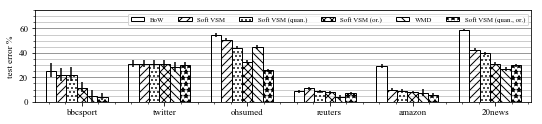

In [12]:
%matplotlib inline

from itertools import chain, cycle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams


def flip(items, ncol):
    return chain(*[items[i::ncol] for i in range(ncol)])

num_bars = len(configurations)
num_datasets = len(dataset_names)
bar_width = 1.0 / (num_bars + 2)
bar_ys, bar_yerrs_lower, bar_yerrs_upper = list(zip(*map(lambda x: zip(*x), (
    (
        (
            100 * (1.0 - results[name][configuration].accuracy()[0]),
            100 * (results[name][configuration].accuracy()[2] - results[name][configuration].accuracy()[0]),
            100 * (results[name][configuration].accuracy()[0] - results[name][configuration].accuracy()[1]),
        )
        for name in dataset_names
    )
    for configuration in configurations
))))
bar_xs = [
    np.arange(num_datasets) + bar_width * (bar_number - 0.5 * (num_bars - 1))
    for bar_number in range(num_bars)
]
hatches = (' ', '///', '...', 'xxx', '\\\\\\', '**', 'xx', '.', '*', 'o', 'O')

rcParams['font.size'] = 9
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman', 'TeX Gyre Termes']
# plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(7.6, 1.8))
# fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
for x, y, yerr_lower, yerr_upper, label, hatch in zip(
            bar_xs,
            bar_ys,
            bar_yerrs_lower,
            bar_yerrs_upper,
            map(lambda x: configuration_names[x], configurations),
            cycle(hatches),
        ):
    yerr = (yerr_lower, yerr_upper)
    plt.bar(x, y, width=bar_width, edgecolor='black', color='w', yerr=yerr, hatch=hatch, capsize=0, label=label)
    # plt.bar(x, y, width=bar_width, edgecolor='black', yerr=yerr, capsize=0, label=label)

handles, labels = ax.get_legend_handles_labels()
ncol = num_bars
plt.legend(flip(handles, ncol), flip(labels, ncol), loc='best', ncol=ncol, prop={'size': 6.84})

plt.xticks(bar_xs[num_bars // 2], dataset_names)
plt.minorticks_on()
plt.ylabel('test error %')
plt.xlim((-0.5 * (num_bars + 2) * bar_width, num_datasets - 1 + 0.5 * (num_bars + 2) * bar_width))
plt.ylim(0, 75)
plt.grid(axis='y', which='major', color='k', alpha=0.5)
plt.grid(axis='y', which='minor', color='k', alpha=0.25)
plt.tight_layout()
plt.savefig('figures/classification-test_error.pdf')
plt.show()

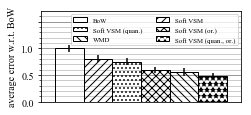

In [13]:
bar_ys = list(map(lambda x: sum(x) / len(x), bar_ys))
bar_yerrs_lower = list(map(lambda x: sum(x) / len(x), bar_yerrs_lower))
bar_yerrs_upper = list(map(lambda x: sum(x) / len(x), bar_yerrs_upper))

baseline_configuration = ('vsm', 'bow', 'inner_product', 32)
baseline_configuration_index = configurations.index(baseline_configuration)
baseline_y = bar_ys[baseline_configuration_index]

bar_ys = list(map(lambda x: (x / baseline_y, ), bar_ys))
bar_yerrs_lower = list(map(lambda x: (x / baseline_y, ), bar_yerrs_lower))
bar_yerrs_upper = list(map(lambda x: (x / baseline_y, ), bar_yerrs_upper))
# bar_yerrs_lower[baseline_configuration_index] = (0.0, )
# bar_yerrs_upper[baseline_configuration_index] = (0.0, )
bar_xs = [
    bar_width * (bar_number - 0.5 * (num_bars - 1))
    for bar_number in range(num_bars)
]

fig = plt.figure(figsize=(3.6, 1.7))
# fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
for x, y, yerr_lower, yerr_upper, label, hatch in zip(
            bar_xs,
            bar_ys,
            bar_yerrs_lower,
            bar_yerrs_upper,
            map(lambda x: configuration_names[x], configurations),
            cycle(hatches),
        ):
    yerr = (yerr_lower, yerr_upper)
    plt.bar(x, y, width=bar_width, edgecolor='black', color='w', yerr=yerr, hatch=hatch, capsize=0, label=label)
    # plt.bar(x, y, width=bar_width, edgecolor='black', yerr=yerr, capsize=0, label=label)

handles, labels = ax.get_legend_handles_labels()
ncol = 2
plt.legend(flip(handles, ncol), flip(labels, ncol), loc='best', ncol=ncol, prop={'size': 6.84})

# plt.xticks(
#     np.add(-0.5 * num_bars * bar_width + 0.5 * bar_width, np.arange(num_bars) * bar_width),
#     map(lambda x: configuration_names[x], configurations)
# )
plt.xticks((), ())
plt.yticks((0.0, 0.5, 1.0, 1.5), (0.0, 0.5, 1.0))
plt.minorticks_on()
plt.ylabel('average error w.r.t. BoW')
plt.xlim((-0.5 * (num_bars + 1) * bar_width, 0.5 * (num_bars + 1) * bar_width))
plt.ylim((0.0, 1.7))
plt.grid(axis='y', which='major', color='k', alpha=0.5)
plt.grid(axis='y', which='minor', color='k', alpha=0.25)
plt.tight_layout()
plt.savefig('figures/classification-avg_test_error_ratio.pdf')
plt.show()

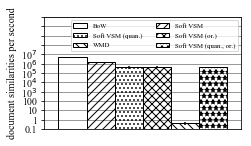

In [19]:
import numpy as np

from common import read_speeds

bar_ys, bar_yerrs_lower, bar_yerrs_upper = list(zip(*map(lambda x: zip(*x), (
    (
        (
            read_speeds(results[name][configuration] for name in dataset_names)[0],
            read_speeds(results[name][configuration] for name in dataset_names)[0] -
                read_speeds(results[name][configuration] for name in dataset_names)[1],
            read_speeds(results[name][configuration] for name in dataset_names)[2] -
                read_speeds(results[name][configuration] for name in dataset_names)[0],
        ),
    )
    for configuration in configurations
))))

fig = plt.figure(figsize=(3.6, 2.1))
# fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
for x, y, yerr_lower, yerr_upper, label, hatch in zip(
            bar_xs,
            bar_ys,
            bar_yerrs_lower,
            bar_yerrs_upper,
            map(lambda x: configuration_names[x], configurations),
            cycle(hatches),
        ):
    yerr = (yerr_lower, yerr_upper)
    plt.bar(x, y, width=bar_width, edgecolor='black', color='w', yerr=yerr, hatch=hatch, capsize=0, label=label)
    # plt.bar(x, y, width=bar_width, edgecolor='black', yerr=yerr, capsize=0, label=label)

handles, labels = ax.get_legend_handles_labels()
ncol = 2
plt.legend(flip(handles, ncol), flip(labels, ncol), loc='best', ncol=ncol, prop={'size': 6.84})

plt.xticks((), ())
plt.yscale('log')
plt.yticks(
    (10.0**np.arange(-1, 12)),
    ('0.1', '1', '10', '100', '10$^3$', '10$^4$', '10$^5$', '10$^6$', '10$^7$'),
)
plt.minorticks_on()
plt.ylabel('document similarities per second')
plt.xlim((-0.5 * (num_bars + 1) * bar_width, 0.5 * (num_bars + 1) * bar_width))
plt.grid(axis='y', which='major', color='k', alpha=0.5)
plt.grid(axis='y', which='minor', color='k', alpha=0.25)
plt.tight_layout()
plt.ylim((10**-1, 10**11))
plt.savefig('figures/classification-speed.pdf')
plt.show()

In [16]:
from itertools import product, combinations

from common import f_test

parameters = list(product(dataset_names, combinations(configurations, 2)))
result_pairs = map(lambda x: (results[x[0]][x[1][0]], results[x[0]][x[1][1]]), parameters)
test_results = f_test(result_pairs)

for (dataset, (first_configuration, second_configuration)), test_result in zip(parameters, test_results):
    if not test_result:
        first_configuration_name = configuration_names[first_configuration]
        second_configuration_name = configuration_names[second_configuration]
        print("Not different mean: {}, {}, {}".format(
            dataset,
            first_configuration_name,
            second_configuration_name,
    ))

Not different mean: bbcsport, Soft VSM, Soft VSM (quan.)
Not different mean: twitter, BoW, Soft VSM
Not different mean: twitter, Soft VSM, Soft VSM (quan.)
Not different mean: twitter, Soft VSM, Soft VSM (ortho.)
Not different mean: twitter, Soft VSM (quan.), Soft VSM (ortho.)
